In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.colors as mcolors


import multiprocessing
from multiprocessing import Pool
import concurrent.futures
import os

In [ ]:
K = 4
S_0 = 5
sigma = 0.2
r = 0.05
a = 0.15
b = 1
M = 4

L=3

L_N_l = [2000]*5
Nsim = np.sum(L_N_l)

# Monte Carlo standard (MC)

In [ ]:
def sim_dW(M,L,T=1):

    """

     
    nombre de pas = M**L
    T: période entière (toujours égale à 1 d'après l'énoncé)


    La fonction retourne les Npas=M**L incréments du mouvement brownien

    """
    dt = T/M**L

    return (np.random.normal(0,1,M**L)*m.sqrt(dt))

In [ ]:
dW = sim_dW(4,4,T=1)

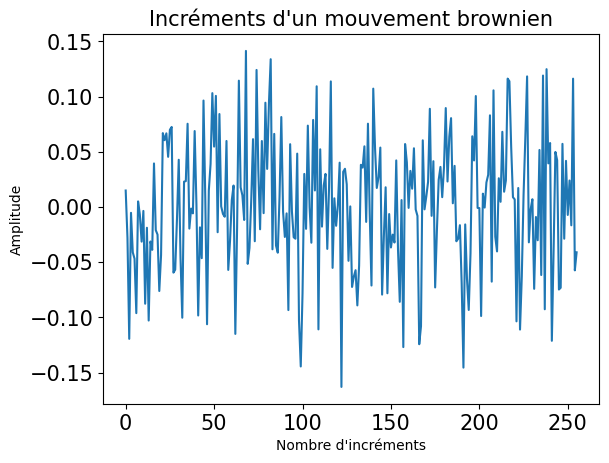

In [ ]:
title = "Incréments d'un mouvement brownien"
plt.plot(dW)
plt.xlabel("Nombre d'incréments")
plt.ylabel("Amplitude")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
def sim_CIR(a,b,sigma,S_0,M,L,T=1):

    """
    Simulation d'un processus CIR avec comme paramètres: a,b,sigma

    S_0 : prix de l'underlying à la date t_0 = 0
    M**L : nombre de pas
    T: période entière (toujours égale à 1 d'après l'énoncé)

    -> T/M**L = 1/M**L est le pas de discrétisation

    """
    if 2*a*b <= sigma**2:

      return("Il faut choisir des paramètres a, b et sigma adaptés")

    Npas = M**L
    S_t = [S_0]
    dt = T/Npas

    dW = sim_dW(M,L)

    for t in range(1,Npas+1):

        dS = a*(b-S_t[t-1])*dt + sigma*np.sqrt(S_t[t-1])*dW[t-1]

        S_t.append(S_t[t-1]+dS)
  
    return np.asarray(S_t)
     

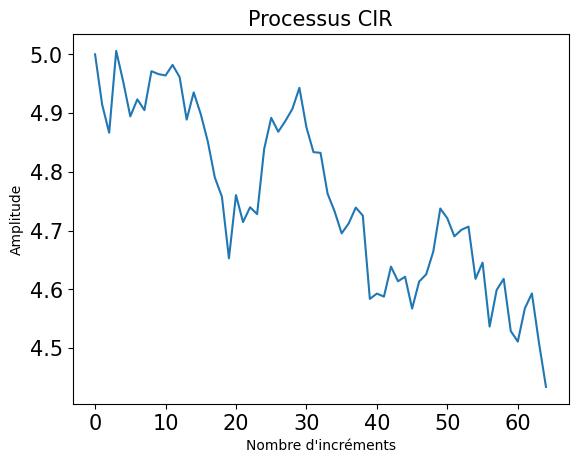

In [ ]:
CIR_MC = sim_CIR(a,b,sigma,S_0,M,L,T=1)


plt.plot(CIR_MC)
title = "Processus CIR"
plt.xlabel("Nombre d'incréments")
plt.ylabel("Amplitude")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
def sim_stocks(Nsim,a,b,sigma,S_0,M,L,T=1):

    Npas = M**L

    S = np.zeros(shape=(Nsim,Npas+1))

    for i in range(Nsim):

        aj = sim_CIR(a,b,sigma,S_0,M,L,T=1).T

        S[i:] = aj

    return S


In [ ]:
X = sim_stocks(Nsim,a,b,sigma,S_0,M,L,T=1)

stocks_MC = pd.DataFrame(X)
stocks_MC.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,5.0,4.899059,4.873146,4.737300,4.686692,4.703669,4.671674,4.662736,4.729436,4.803552,...,4.354591,4.381371,4.331797,4.398108,4.436653,4.350444,4.397302,4.327531,4.249961,4.257988
1,5.0,4.960305,4.923951,4.983909,5.005602,5.018945,4.988943,5.053019,4.952444,4.907878,...,4.794441,4.717184,4.725503,4.720498,4.732940,4.713181,4.743594,4.766820,4.794653,4.686615
2,5.0,4.957203,4.952209,4.967938,4.891013,4.881708,4.871979,4.885661,4.879554,4.906101,...,4.413460,4.348890,4.287672,4.235317,4.246838,4.200631,4.218482,4.255417,4.365902,4.466687
3,5.0,5.115897,5.034338,4.927064,4.804825,4.907334,4.893386,4.778077,4.754831,4.743652,...,4.394414,4.397154,4.453588,4.449090,4.450900,4.407013,4.387279,4.344253,4.396285,4.336713
4,5.0,4.997027,5.027756,5.035796,5.103569,5.089225,5.055757,5.041685,5.026321,4.972890,...,4.497284,4.457969,4.529138,4.403253,4.416273,4.307415,4.296704,4.272466,4.345638,4.400320


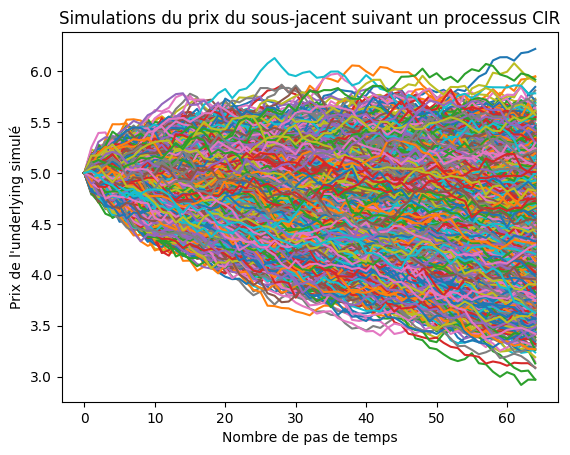

In [ ]:
plt.plot(stocks_MC.T)
plt.title("Simulations du prix du sous-jacent suivant un processus CIR")
plt.xlabel("Nombre de pas de temps")
plt.ylabel("Prix de l'underlying simulé")
plt.show()

In [ ]:
def MC_call_asian(Nsim,a,b,sigma,S_0,r,K,M,L,T=1):

    Lsim_stocks = sim_stocks(Nsim,a,b,sigma,S_0,M,L)
    
    prices = []
    C = []
    
    for i in range(Nsim):
        
        prices.append(Lsim_stocks[i,:].mean())
        
        C.append(max(prices[i]-K,0)*m.exp(-r*T))
        
    arithmetic_C_price  = np.mean(C)
    
    return arithmetic_C_price

In [ ]:
print(MC_call_asian(Nsim,a,b,sigma,S_0,r,K,M,L,T=1))

0.678176324075634


# Multi Level Monte Carlo (MLMC)

In [ ]:
def incréments_normal(l,M):
    
    increments_normal_fine = np.random.normal(0,1,M**l)* m.sqrt(M**(-l))
    increments_normal_coarse = []

    i=0

    while i <= M**l-1:
      increments_normal_coarse.append(increments_normal_fine[i:i+M].sum())
      i = i+M

    return(increments_normal_fine,increments_normal_coarse)

In [ ]:
def step_simul_1(a,b,sigma,S_0,l,M):
    
    increments_normal_fine, increments_normal_coarse = incréments_normal(l,M)
  
    S_fine = [S_0]
    S_coarse = [S_0]

    dt_fine = M**(-l)
    dt_coarse = M**(-l+1)

    for i in range(1,M**l +1):
        
        dS_fine = a*(b-S_fine[i-1])*dt_fine + sigma*np.sqrt(S_fine[i-1])*increments_normal_fine[i-1]
        S_fine.append(S_fine[i-1] + dS_fine)    

        if i<= M**(l-1):    
          dS_coarse = a*(b-S_coarse[i-1])*dt_coarse + sigma*np.sqrt(S_coarse[i-1])*increments_normal_coarse[i-1]
          S_coarse.append(S_coarse[i-1] + dS_coarse)              

    return(S_fine, S_coarse)

In [ ]:
def step_simul_Nl(a,b,sigma,S_0,l,N_l,M,T=1):

    Nl_S_fine = np.zeros(shape=(N_l,M**l+1))
    Nl_S_coarse = np.zeros(shape=(N_l,M**(l-1)+1))

    for i in range(N_l):

        aj = step_simul_1(a,b,sigma,S_0,l,M)

        Nl_S_fine[i:] = np.array(aj[0]).T
        Nl_S_coarse[i:] = np.array(aj[1]).T

    
    return(Nl_S_fine,Nl_S_coarse)

In [ ]:
def liste_payoff(a,b,sigma,S_0,l,N_l,M,K,r,T=1):

    if l == 0:
      _, Nl_S_fine = step_simul_Nl(a,b,sigma,S_0,l+1,N_l,M,T=1)
      Mean_fine = Nl_S_fine.mean(axis=1)
      payoff_fine = np.maximum(Mean_fine - K , 0) * m.exp(-r*T) 
      return(payoff_fine,np.zeros(N_l))

    Nl_S_fine, Nl_S_coarse = step_simul_Nl(a,b,sigma,S_0,l,N_l,M,T=1)
    Mean_fine = Nl_S_fine.mean(axis=1)
    Mean_coarse =  Nl_S_coarse.mean(axis=1)
    
    # Calculer les payoffs pour les deux niveaux L et L-1

    payoff_fine = np.maximum(Mean_fine - K , 0) * m.exp(-r*T)   
    payoff_coarse = np.maximum(Mean_coarse - K , 0)* m.exp(-r*T) 
   
    return (payoff_fine,payoff_coarse)

In [ ]:
def estimateur_Yl(a,b,sigma,S_0,l,N_l,M,K,r,T=1):
    
    payoff_fine, payoff_coarse = liste_payoff(a,b,sigma,S_0,l,N_l,M,K,r,T=1)
    
    diff = payoff_fine - payoff_coarse

    result_l = diff.mean()

    variance_l = np.var(diff)

    return(result_l,variance_l, payoff_fine, payoff_coarse)

In [ ]:
def MLMC_call_asian(a,b,sigma,S_0,L_N_l,M,K,r,T=1):
  """
  L_N_l est la liste qui contient N_l pour chaque l

  """
  C = 0 
  V_l = []
  for l in range(0,len(L_N_l)):
    
    X = estimateur_Yl(a,b,sigma,S_0,l,L_N_l[l],M,K,r,T=1)
    C = C + X[0]
    V_l.append(X[1])

  return(C,V_l)

In [ ]:
MLMC_call_asian(a,b,sigma,S_0,L_N_l,M,K,r,T=1)

(0.677470277765849,
 [0.046418337278071944,
  0.008344470417727252,
  0.0009138305702758272,
  6.794763482712951e-05,
  5.0439878005759436e-06])

# Comparaison de la CPU time et de la variance entre MC standard et MLMC avec paramètres non optimaux

In [ ]:
def variance_cpu_mc__process(args):
    Nsim,a,b,sigma,S_0,r,K,M,L,T = args
    np.random.seed((os.getpid() * int(time.time())) % 123456789)
    start = time.time()
    C_approx = MC_call_asian(Nsim,a,b,sigma,S_0,r,K,M,L,T=1)
    stop = time.time()
    return C_approx, stop-start

def variance_cpu_mc(n_estimators, Nsim,a,b,sigma,S_0,r,K,M,L,T=1):
    estimators = np.zeros(n_estimators)
    cpu_times = np.zeros(n_estimators)
    
    range_ = range(n_estimators)
    with concurrent.futures.ProcessPoolExecutor() as exe:
        args = [(Nsim,a,b,sigma,S_0,r,K,M,L,T) for _ in range_]
        async_results = list(exe.map(variance_cpu_mc__process, args))
        
        for i in range_:
            Y_hat, cpu_time = async_results[i]
            estimators[i] = Y_hat
            cpu_times[i] = cpu_time
            
    mean_cpu_time = cpu_times.mean()
    mean_C_estimated = estimators.mean()
    variance = np.var(estimators)
    return variance, mean_C_estimated, mean_cpu_time, estimators

In [ ]:
def variance_cpu_mlmc__process(args):
    a,b,sigma,S_0,L_N_l,M,K,r,T = args
    np.random.seed((os.getpid() * int(time.time())) % 123456789)
    start = time.time()
    C_approx, _ = MLMC_call_asian(a,b,sigma,S_0,L_N_l,M,K,r,T=1)
    stop = time.time()
    return C_approx, stop-start

def variance_cpu_mlmc(n_estimators, a,b,sigma,S_0,L_N_l,M,K,r,T=1):
    estimators = np.zeros(n_estimators)
    cpu_times = np.zeros(n_estimators)
    
    range_ = range(n_estimators)
    with concurrent.futures.ProcessPoolExecutor() as exe:
        args = [(a,b,sigma,S_0,L_N_l,M,K,r,T) for _ in range_]
        async_results = list(exe.map(variance_cpu_mlmc__process, args))
        
        for i in range_:
            Y_hat, cpu_time = async_results[i]
            estimators[i] = Y_hat
            cpu_times[i] = cpu_time
            
    mean_cpu_time = cpu_times.mean()
    mean_C_estimated = estimators.mean()
    variance = np.var(estimators)
    return variance, mean_C_estimated, mean_cpu_time, estimators

In [ ]:
n_estimators = 10

In [ ]:
var_mc, mean_C_mc, mean_cpu_mc = variance_cpu_mc(n_estimators, Nsim,a,b,sigma,S_0,r,K,M,L,T=1)

100%|██████████| 10/10 [01:40<00:00, 10.05s/it]


In [ ]:
var_mlmc, mean_C_mlmc, mean_cpu_mlmc = variance_cpu_mlmc(n_estimators, a,b,sigma,S_0,L_N_l,M,K,r,T=1)

100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


In [ ]:
print(f"Estimation MC = {mean_C_mc} // Estimation MLMC = {mean_C_mlmc}")
print(f"Variance MC = {var_mc} // Variance MLMC = {var_mlmc}")
print(f"Temps moyen d'execution MC = {round(mean_cpu_mc, 3)}s // Temps moyen d'execution MLMC = {round(mean_cpu_mlmc, 3)}s")

Estimation MC = 0.6795128500481414 // Estimation MLMC = 0.6799356665973326
Variance MC = 7.323613929925969e-06 // Variance MLMC = 5.0561870020626613e-05
Temps moyen d'execution MC = 10.045s // Temps moyen d'execution MLMC = 3.161s


# Optimisation des paramètres $L$ et $N_L$ de MLMC

In [ ]:
def re_estimateur_Yl(prev_payoff_fine, prev_payoff_coarse, a,b,sigma,S_0,l,nb_extra_samples,M,K,r,T=1):
    
    payoff_fine, payoff_coarse = liste_payoff(a,b,sigma,S_0,l,nb_extra_samples,M,K,r,T=1)

    payoff_fine = np.append(prev_payoff_fine, payoff_fine)
    payoff_coarse = np.append(prev_payoff_coarse, payoff_coarse)
    
    diff = payoff_fine - payoff_coarse

    result_l = diff.mean()

    variance_l = np.var(diff)

    return(result_l,variance_l, payoff_fine, payoff_coarse)

In [ ]:
def extra_samples_step(l, Nl, Y_hat, Vl, payoffs):
    if Nl[l] > len(payoffs[l][0]): #il faut reevaluer Yl avec plus de samples
        nb_extra_samples = Nl[l] - len(payoffs[l][0])
        Y_hat_l, V_l, payoff_fine_l, payoff_coarse_l = re_estimateur_Yl(payoffs[l][0], payoffs[l][1], a,b,sigma,S_0,l,nb_extra_samples,M,K,r,T=1)
        Y_hat[l] = Y_hat_l
        Vl[l] = V_l
        payoffs[l] = [payoff_fine_l, payoff_coarse_l]
    elif Nl[l] == len(payoffs[l][0]):
        pass # on a le bon nombre de samples
    else:
        #Nl[l] < len(payoffs[l][0]) donc on a trop de samples dans les payoffs
        Y_hat_l, V_l, payoff_fine_l, payoff_coarse_l = estimateur_Yl(a,b,sigma,S_0,l,Nl[l],M,K,r,T=1)
        Y_hat[l] = Y_hat_l
        Vl[l] = V_l
        payoffs[l] = [payoff_fine_l, payoff_coarse_l]
        
def extra_samples(L, Nl, Y_hat, Vl, payoffs):
    with Pool() as p:
        async_results = [p.apply_async(extra_samples_step, args=(l, Nl, Y_hat, Vl, payoffs))
                        for l in range(L+1)]
        for i in range(L+1):
            res = async_results[i].get()
    return

In [ ]:
def mlmc_adaptative(eps, a,b,sigma,S_0,M,K,r,T=1):
    if __name__ == '__main__':
      ## step 1 ##
        L = 0

        Nl = []
        Vl = []
        payoffs = []
        Y_hat = []

        while True:
            ## step 2 ## 
            NL = int(1e4)
            Y_hat_L, V_L, payoff_fine_L, payoff_coarse_L = estimateur_Yl(a,b,sigma,S_0,L,NL,M,K,r,T=1)

            V_L = np.sum(V_L)
            Y_hat.append(Y_hat_L)
            Vl.append(V_L)
            payoffs.append([payoff_fine_L, payoff_coarse_L])

            ## step 3 ##
            sum_variances = 0
            for l in range(L+1):
                h_l = M**(-l)
                sum_variances += np.sqrt(Vl[l]/h_l)

            error_term = 2 * eps**(-2)
            Nl = [m.ceil(error_term * np.sqrt(Vl[l] * M**(-l)) * sum_variances) for l in range(L+1)]

            ## step 4 ##
            
            for l in range(L+1):
                if Nl[l] > len(payoffs[l][0]): #il faut reevaluer Yl avec plus de samples
                    nb_extra_samples = Nl[l] - len(payoffs[l][0])
                    Y_hat_l, V_l, payoff_fine_l, payoff_coarse_l = re_estimateur_Yl(payoffs[l][0], payoffs[l][1], a,b,sigma,S_0,l,nb_extra_samples,M,K,r,T=1)
                    Y_hat[l] = Y_hat_l
                    Vl[l] = V_l
                    payoffs[l] = [payoff_fine_l, payoff_coarse_l]
                elif Nl[l] == len(payoffs[l][0]):
                    pass # on a le bon nombre de samples
                else:
                    #Nl[l] < len(payoffs[l][0]) donc on a trop de samples dans les payoffs
                    Y_hat_l, V_l, payoff_fine_l, payoff_coarse_l = estimateur_Yl(a,b,sigma,S_0,l,Nl[l],M,K,r,T=1)
                    Y_hat[l] = Y_hat_l
                    Vl[l] = V_l
                    payoffs[l] = [payoff_fine_l, payoff_coarse_l]
            
            #extra_samples(L, Nl, Y_hat, Vl, payoffs)

            ## step 5 ##
            if L >= 2:
                #on teste la convergence, avec equation 11
                diff_estimateurs = abs(Y_hat[-1] - M**(-1) * Y_hat[-2])
                tolerance = 1/np.sqrt(2) * (M**2 - 1)*eps
                if diff_estimateurs < tolerance:
                    return Y_hat, Vl, Nl

            ## step 6 ##
            L += 1

# Comparaison de la CPU time et de la variance entre MC standard, MLMC avec paramètres non optimaux et MLMC avec paramètres adaptés (optimisés)

In [ ]:
def variance_cpu_mlmc_adaptative__process(args):
    eps,a,b,sigma,S_0,M,K,r,T = args
    np.random.seed((os.getpid() * int(time.time())) % 123456789)
    start = time.time()
    Y_hat, _, _= mlmc_adaptative(eps, a,b,sigma,S_0,M,K,r,T=1)
    stop = time.time()

    return Y_hat, stop-start

def variance_cpu_mlmc_adaptative(n_estimators, eps,a,b,sigma,S_0,M,K,r,T=1):
    estimators = np.zeros(n_estimators)
    cpu_times = np.zeros(n_estimators)
    
    range_ = range(n_estimators)
    with concurrent.futures.ProcessPoolExecutor() as exe:
        args = [(eps,a,b,sigma,S_0,M,K,r,T) for _ in range_]
        async_results = list(exe.map(variance_cpu_mlmc_adaptative__process, args))
        
        for i in range_:
            Y_hat, cpu_time = async_results[i]
            estimators[i] = np.sum(Y_hat)
            cpu_times[i] = cpu_time
            
    mean_cpu_time = cpu_times.mean()
    mean_C_estimated = estimators.mean()
    variance = np.var(estimators)
    return variance, mean_C_estimated, mean_cpu_time, estimators

In [ ]:
def comparaison_variance(n_estimators, N_sim_mc, L_N_l, eps, a,b,sigma,S_0,r,K,M,L,T=1, show=True):
    var_mc, mean_C_mc, mean_cpu_mc, _ = variance_cpu_mc(n_estimators, N_sim_mc,a,b,sigma,S_0,r,K,M,L,T=1)
    var_mlmc, mean_C_mlmc, mean_cpu_mlmc, _ = variance_cpu_mlmc(n_estimators, a,b,sigma,S_0,L_N_l,M,K,r,T=1)
    var_mlmc_ad, mean_C_mlmc_ad, mean_cpu_mlmc_ad, _ = variance_cpu_mlmc_adaptative(n_estimators, eps,a,b,sigma,S_0,M,K,r,T=1)

    if show:
        print()
        print(f"  MC ({N_sim_mc} sim)   --> Estimation = {mean_C_mc} // Variance = {var_mc} // CPU moyen = {round(mean_cpu_mc, 3)}s")
        print(f"   MLMC (Nl={L_N_l})    --> Estimation = {mean_C_mlmc} // Variance = {var_mlmc} // CPU moyen = {round(mean_cpu_mlmc, 3)}s")
        print(f"MLMC_adpt (eps = {eps}) --> Estimation = {mean_C_mlmc_ad} // Variance = {var_mlmc_ad} // CPU moyen = {round(mean_cpu_mlmc_ad, 3)}s")
    
    return var_mc, mean_C_mc, mean_cpu_mc, var_mlmc, mean_C_mlmc, mean_cpu_mlmc, var_mlmc_ad, mean_C_mlmc_ad, mean_cpu_mlmc_ad

In [ ]:
n_estimators = 20
L = 3
L_N_l = [2000]*(L+1)
N_sim_mc = np.sum(L_N_l)
eps = 1e-3

In [ ]:
x = comparaison_variance(n_estimators, N_sim_mc, L_N_l, eps, a,b,sigma,S_0,r,K,M,L,T=1)


  MC (8000 sim)   --> Estimation = 0.6794515653488846 // Variance = 6.48488090173395e-06 // CPU moyen = 4.016s
   MLMC (Nl=[2000, 2000, 2000, 2000])    --> Estimation = 0.6803430673067129 // Variance = 3.091264034506962e-05 // CPU moyen = 1.861s
MLMC_adpt (eps = 0.001) --> Estimation = 0.6795630926998179 // Variance = 5.999201110494719e-07 // CPU moyen = 312.566s


(6.48488090173395e-06,
 0.6794515653488846,
 4.015954327583313,
 3.091264034506962e-05,
 0.6803430673067129,
 1.861133050918579,
 5.999201110494719e-07,
 0.6795630926998179,
 312.5655279517174)

# Variations des paramètres

## Variation de M 

In [ ]:
eps_var_M = 1e-3
n_estimators_var_M = 30
N_sim_mc_var_M = 8000
L_N_l_var_M = [2000]*4
M_loops = range(2, 8)

variances = []
full_cpu_times = []
cpu_times = []

for i in tqdm(range(len(M_loops))):
    M_loop = M_loops[i]
    start = time.time()
    var_mc, mean_C_mc, mean_cpu_mc, var_mlmc, mean_C_mlmc, mean_cpu_mlmc, var_mlmc_ad, mean_C_mlmc_ad, mean_cpu_mlmc_ad = comparaison_variance(n_estimators_var_M, 
                                                                                                                                               N_sim_mc_var_M,
                                                                                                                                               L_N_l_var_M, 
                                                                                                                                               eps_var_M, 
                                                                                                                                               a,b,sigma,S_0,r,K,M,L,T=1, show=False)
    stop = time.time()

    full_cpu_times.append(stop-start)
    variances.append([var_mc, var_mlmc, var_mlmc_ad])
    cpu_times.append([mean_cpu_mc, mean_cpu_mlmc, mean_cpu_mlmc_ad])

100%|██████████| 6/6 [40:38<00:00, 406.45s/it]


In [ ]:
var_mc = [variance[0] for variance in variances]
var_mlmc = [variance[1] for variance in variances]
var_mlmc_ad = [variance[2] for variance in variances]

cpu_mc = [cpu_time[0] for cpu_time in cpu_times]
cpu_mlmc = [cpu_time[1] for cpu_time in cpu_times]
cpu_mlmc_ad = [cpu_time[2] for cpu_time in cpu_times]

variance_per_method = [var_mc, var_mlmc, var_mlmc_ad]
cpu_per_method = [cpu_mc, cpu_mlmc, cpu_mlmc_ad]
names = ['MC', 'MLMC', 'MLMC Adpt']

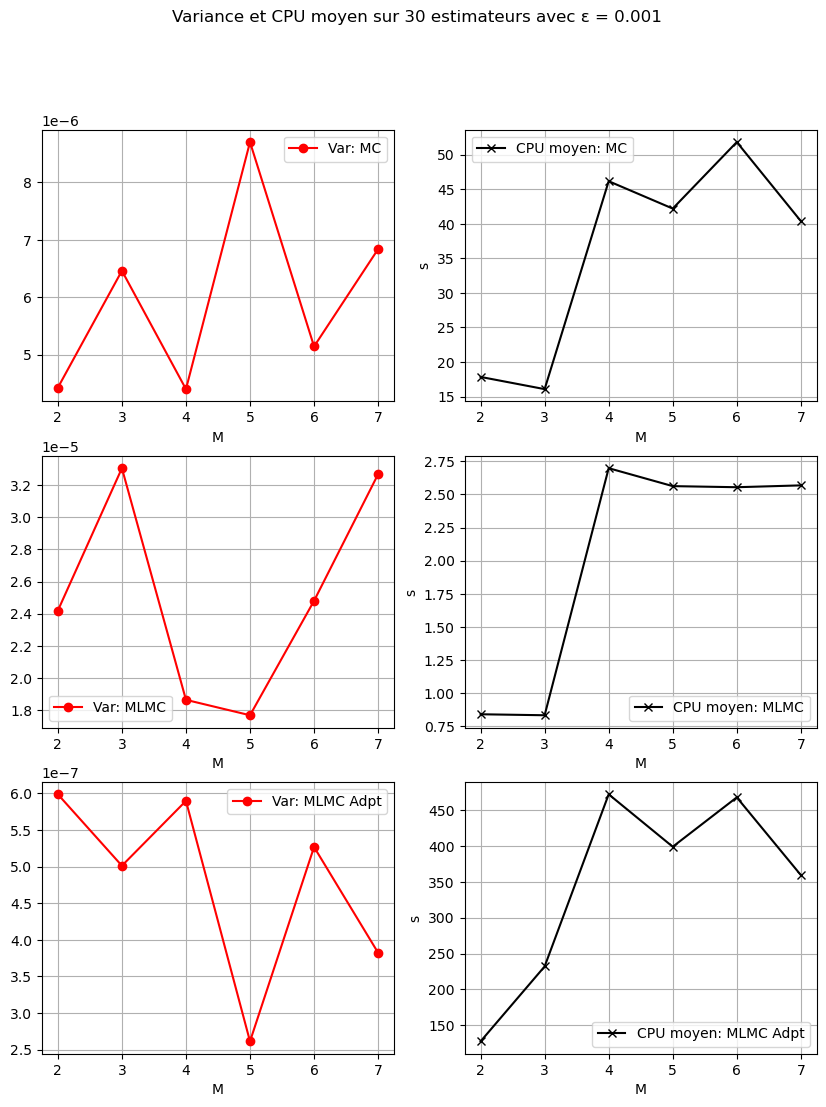

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

for i, ax in enumerate(axs):
    ax[0].plot(M_loops, variance_per_method[i], c = 'r', label = f'Var: {names[i]}', marker='o')
    ax[0].legend(loc='best')
    ax[0].grid('on')
    ax[0].set_xlabel('M')

    ax[1].plot(M_loops, cpu_per_method[i], c = 'black', label = f'CPU moyen: {names[i]}', marker='x')
    ax[1].legend(loc='best')
    ax[1].grid('on')
    ax[1].set_xlabel('M')
    ax[1].set_ylabel('s')

plt.suptitle(f'Variance et CPU moyen sur {n_estimators_var_M} estimateurs avec ε = {eps_var_M}')
plt.show()

## Variation de epsilon

In [ ]:
times = []
Nls = []
epsilons = np.linspace(1e-1, 3e-4, 40)
for i in tqdm(range(len(epsilons))):
    eps = epsilons[i]
    start = time.time()
    Y_hat, Vl, Nl = mlmc_adaptative(eps, a,b,sigma,S_0,M,K,r,T=1)
    stop = time.time()
    times.append(stop-start)
    Nls.append(Nl)

100%|██████████| 40/40 [4:00:00<00:00, 360.02s/it] 


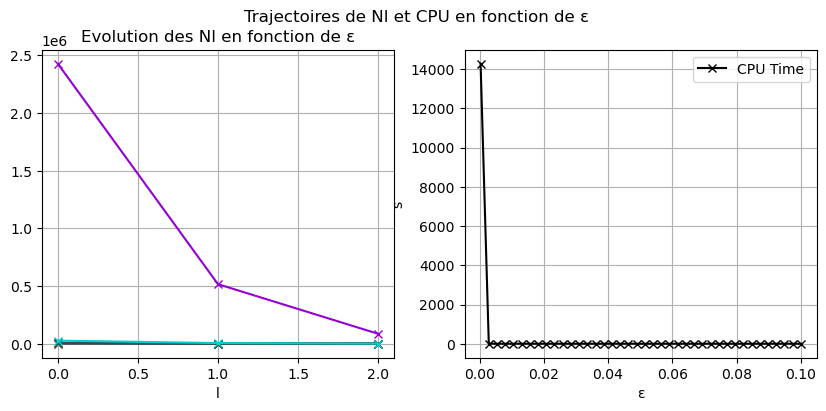

In [ ]:
markers = ["x", "o", "*", "+", "v", ">", "<"]
colors = list(mcolors.CSS4_COLORS.keys())

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i, Nl in enumerate(Nls):
    ax[0].plot(Nl, color = colors[i], marker = "x", label = f"ε={epsilons[i]}")
ax[0].grid('on')
#ax[0].legend(loc='best')
ax[0].set_xlabel("l")
ax[0].set_title("Evolution des Nl en fonction de ε")

ax[1].plot(epsilons[:len(times)], times, c = 'black', label = 'CPU Time', marker='x')
ax[1].legend(loc='best')
ax[1].grid('on')
ax[1].set_xlabel('ε')
ax[1].set_ylabel('s')

plt.suptitle(f'Trajectoires de Nl et CPU en fonction de ε')
plt.show()

### Graphes mieux adaptés

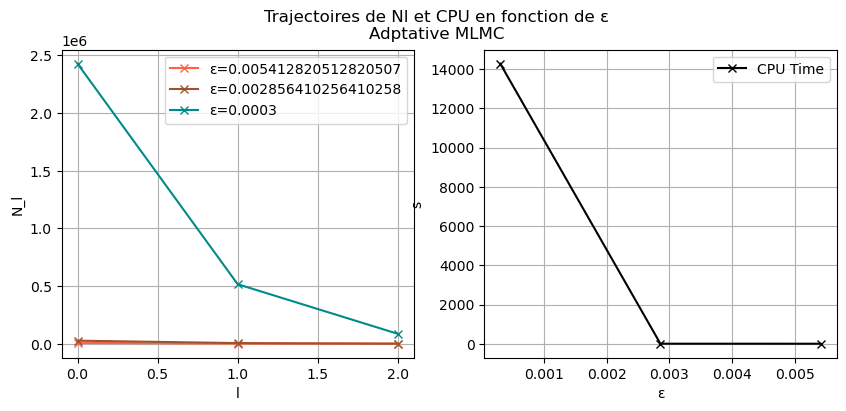

In [ ]:
colors = list(mcolors.CSS4_COLORS.keys())

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

indices = [37, 38, 39]

for i in indices:
    Nl = Nls[i]
    color = np.random.choice(colors)
    ax[0].plot(Nl, color = color, marker = "x", label = f"ε={epsilons[i]}")
ax[0].grid('on')
ax[0].legend(loc='best')
ax[0].set_xlabel("l")
ax[0].set_ylabel('N_l')
#ax[0].set_title("Evolution des Nl en fonction de ε")

ax[1].plot([epsilons[i] for i in indices], [times[i] for i in indices], c = 'black', label = 'CPU Time', marker='x')
ax[1].legend(loc='best')
ax[1].grid('on')
ax[1].set_xlabel('ε')
ax[1].set_ylabel('s')

plt.suptitle(f'Trajectoires de Nl et CPU en fonction de ε\nAdptative MLMC\n')
plt.show()

# MSE

In [ ]:
true_C = 0.6797012714083033 # Cette valeur est trouvé par Monte Carlo standard avec N_sim très grand comme expliqué dans le rapport 

### MSE de MC en fonction de Nsim

In [ ]:
n_approx = 30
Nsim_loop = range(1000, 15000+100, 100)
MSE_MC = []
variances_MC_Nsim = []
mean_cpu_MC_Nsim = []

for i in tqdm(range(len(Nsim_loop))):
    Nsim = Nsim_loop[i]
    variance, mean_C_estimated, mean_cpu_time, estimators = variance_cpu_mc(n_approx, Nsim,a,b,sigma,S_0,r,K,M,L,T=1)
    Mse = np.mean([(x-true_C)**2 for x in estimators])
    MSE_MC.append(Mse)
    variances_MC_Nsim.append(variance)
    mean_cpu_MC_Nsim.append(mean_cpu_time)

100%|██████████| 141/141 [57:19<00:00, 24.39s/it]


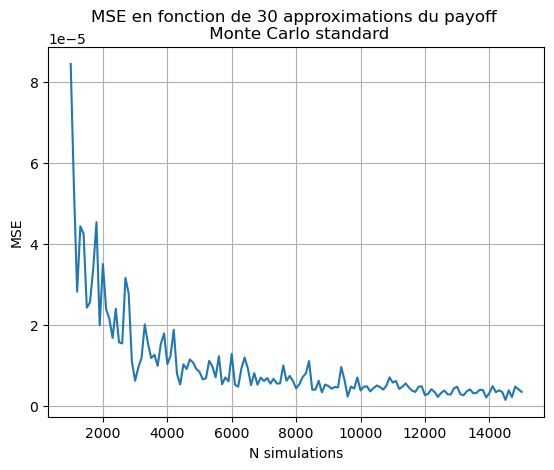

In [ ]:
plt.plot(Nsim_loop[:len(MSE_MC)], variances_MC_Nsim)
plt.title(f'MSE en fonction de {n_approx} approximations du payoff \n Monte Carlo standard')
plt.grid('on')
plt.xlabel('N simulations')
plt.ylabel('MSE')
plt.show()

In [ ]:
plt.plot(Nsim_loop[:len(MSE_MC)], MSE_MC)
plt.title(f'MSE en fonction de {n_approx} approximations du payoff \n Monte Carlo standard')
plt.grid('on')
plt.xlabel('N simulations')
plt.ylabel('MSE')
plt.show()

### MSE de MLMC en fonction de epsilon

In [ ]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

In [ ]:
def draw_graph(eps_loop, MSE_MLMC):
    pl.clf()
    pl.plot(eps_loop[:len(MSE_MLMC)], MSE_MLMC)
    pl.grid('on')
    pl.xlabel('ε')
    pl.ylabel('MSE')
    pl.title('MSE en fonction de la tolérance d\'erreur \n Adaptative MLMC')
    display.display(pl.gcf())
    display.clear_output(wait=True)

In [ ]:
n_approx = 30
eps_loop = np.linspace(1e-1, 3e-4, 100)
MSE_MLMC_eps = []
var_MLMC_eps = []
cpu_MLMC_eps = []

for i in range(len(eps_loop)):
    eps = eps_loop[i]
    variance, mean_C_estimated, mean_cpu_time, estimators = variance_cpu_mlmc_adaptative(n_approx, eps,a,b,sigma,S_0,M,K,r,T=1)
    Mse = np.mean([(x-true_C)**2 for x in estimators])
    MSE_MLMC_eps.append(Mse)
    var_MLMC_eps.append(variance)
    cpu_MLMC_eps.append(mean_cpu_time)
    draw_graph(eps_loop, MSE_MLMC_eps)

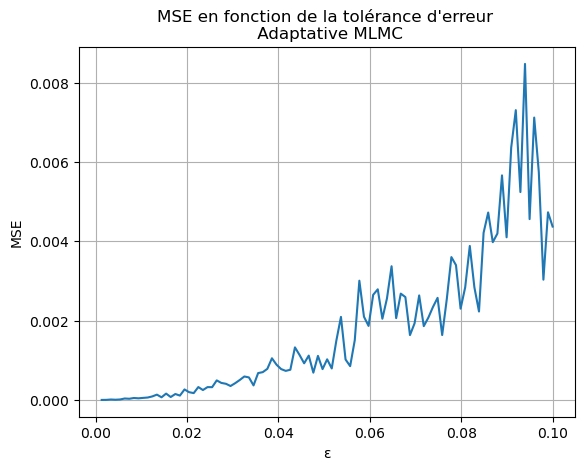

In [ ]:
plt.plot(eps_loop[:len(MSE_MLMC_eps)], MSE_MLMC_eps)
plt.title('MSE en fonction de la tolérance d\'erreur \n Adaptative MLMC')
plt.grid('on')
plt.xlabel('ε')
plt.ylabel('MSE')
plt.show()

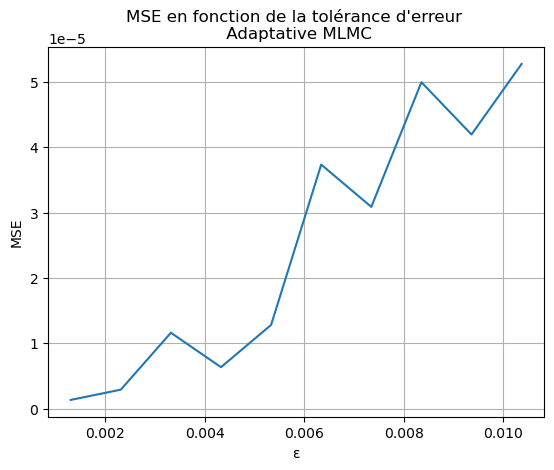

In [ ]:
plt.plot(eps_loop[len(MSE_MLMC_eps)-10:len(MSE_MLMC_eps)], MSE_MLMC_eps[len(MSE_MLMC_eps)-10:])
plt.title('MSE en fonction de la tolérance d\'erreur \n Adaptative MLMC')
plt.grid('on')
plt.xlabel('ε')
plt.ylabel('MSE')
plt.show()

# Comparaison MSE/Variance/CPU entre MC standard et MLMC

In [ ]:
n_approx = 30
Nsim_loop_cmp = range(1000, 20000+100, 100)

MSE_MC_cmp = []
MSE_MC_MLMC_cmp = []

variances_MC_Nsim_cmp = []
mean_cpu_MC_Nsim_cmp = []

variances_MC_MLMC_Nsim_cmp = []
mean_cpu_MC_MLMC_Nsim_cmp = []

for i in tqdm(range(len(Nsim_loop_cmp))):
    Nsim = Nsim_loop_cmp[i]
    
    variance_mc, mean_C_estimated_mc, mean_cpu_time_mc, estimators_mc = variance_cpu_mc(n_approx, Nsim,a,b,sigma,S_0,r,K,M,L,T=1)
    Mse_mc = np.mean([(x-true_C)**2 for x in estimators_mc])
    MSE_MC_cmp.append(Mse_mc)
    variances_MC_Nsim_cmp.append(variance_mc)
    mean_cpu_MC_Nsim_cmp.append(mean_cpu_time_mc)
    
    L = 3
    L_N_l_loop_cmp = [m.ceil(Nsim/(L+1)) for _ in range(L+1)]
    variance_mc_mlmc, mean_C_estimated_mc_mlmc, mean_cpu_time_mc_mlmc, estimators_mc_mlmc = variance_cpu_mlmc(n_approx, a,b,sigma,S_0, L_N_l_loop_cmp, M, K, r,T=1)
    Mse_mc_mlmc = np.mean([(x-true_C)**2 for x in estimators_mc_mlmc])
    MSE_MC_MLMC_cmp.append(Mse_mc_mlmc)
    variances_MC_MLMC_Nsim_cmp.append(variance_mc_mlmc)
    mean_cpu_MC_MLMC_Nsim_cmp.append(mean_cpu_time_mc_mlmc)

100%|██████████| 191/191 [39:22<00:00, 12.37s/it]


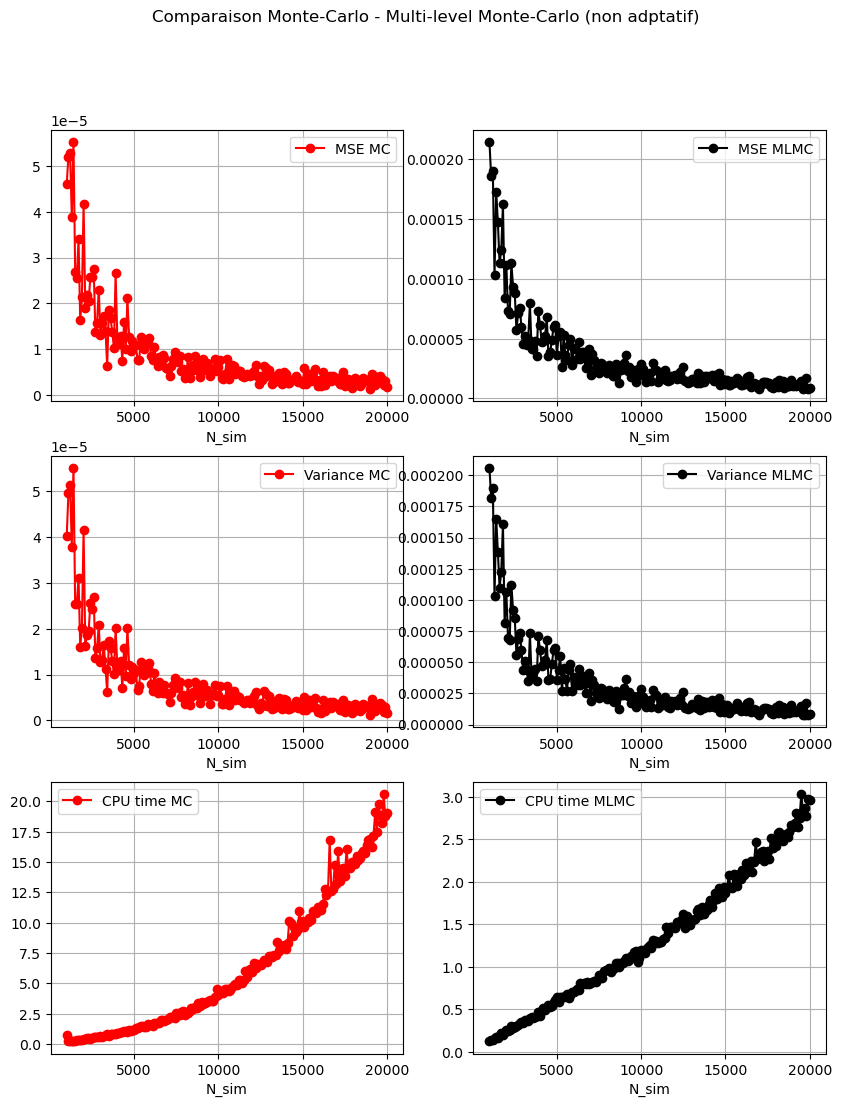

In [ ]:
def plot_perf(ax, perf_mc, perf_mlmc, title):
    ax[0].plot(Nsim_loop_cmp, perf_mc, label = f'{title} MC', marker = 'o', color='red')
    ax[0].grid('on')
    ax[0].legend(loc='best')
    ax[0].set_xlabel("N_sim")
    
    ax[1].plot(Nsim_loop_cmp, perf_mlmc, label = f'{title} MLMC', marker = 'o', color='black')
    ax[1].grid('on')
    ax[1].legend(loc='best')
    ax[1].set_xlabel("N_sim")

fig, axs = plt.subplots(3, 2, figsize=(10, 12))

plot_perf(axs[0], MSE_MC_cmp, MSE_MC_MLMC_cmp, 'MSE')
plot_perf(axs[1], variances_MC_Nsim_cmp, variances_MC_MLMC_Nsim_cmp, 'Variance')
plot_perf(axs[2], mean_cpu_MC_Nsim_cmp, mean_cpu_MC_MLMC_Nsim_cmp, 'CPU time')

plt.suptitle(f'Comparaison Monte-Carlo - Multi-level Monte-Carlo (non adptatif)\n')
plt.show()

# Comparaison MSE/Variance/CPU entre MC et MLMC_adpt (avec paramètres optimaux)

In [ ]:
MSE_MC_MLMC_adpt_eps_cmp = []
MSE_MC_eps_cmp = []

var_MC_MLMC_adpt_eps_cmp = []
var_MC_eps_cmp = []

cpu_MC_MLMC_adpt_eps_cmp = []
cpu_MC_eps_cmp = []

n_estimators = 30

epsilons = np.linspace(1e-1, 3e-4, 30)
for i in range(len(epsilons)):
    eps = epsilons[i]
    variance_ad, mean_C_estimated_ad, mean_cpu_time_ad, estimators_ad = variance_cpu_mlmc_adaptative(n_estimators, eps,a,b,sigma,S_0,M,K,r,T=1)
    Mse_ad = np.mean([(x-true_C)**2 for x in estimators_ad])
    MSE_MC_MLMC_adpt_eps_cmp.append(Mse_ad)
    var_MC_MLMC_adpt_eps_cmp.append(variance_ad)
    cpu_MC_MLMC_adpt_eps_cmp.append(mean_cpu_time_ad)
    
    Nsim = np.sum(Nls[i])
    print(f"i: {i}, Nls -> {Nls[i]}, Nsim = {Nsim}", end='\r', flush=True)
    variance_mc, mean_C_estimated_mc, mean_cpu_time_mc, estimators_mc = variance_cpu_mc(n_approx, Nsim,a,b,sigma,S_0,r,K,M,L,T=1)
    Mse_mc = np.mean([(x-true_C)**2 for x in estimators_mc])
    MSE_MC_eps_cmp.append(Mse_mc)
    var_MC_eps_cmp.append(variance_mc)
    cpu_MC_eps_cmp.append(mean_cpu_time_mc)

In [ ]:
def plot_perf(ax, perf_mc, perf_mlmc, title):
    ax[0].plot(epsilons[-3:], perf_mc[-3:], label = f'{title} MC', marker = 'o', color='red')
    ax[0].grid('on')
    ax[0].legend(loc='best')
    ax[0].set_xlabel("N_sim")
    
    ax[1].plot(epsilons[-3:], perf_mlmc[-3:], label = f'{title} MLMC', marker = 'o', color='black')
    ax[1].grid('on')
    ax[1].legend(loc='best')
    ax[1].set_xlabel("N_sim")

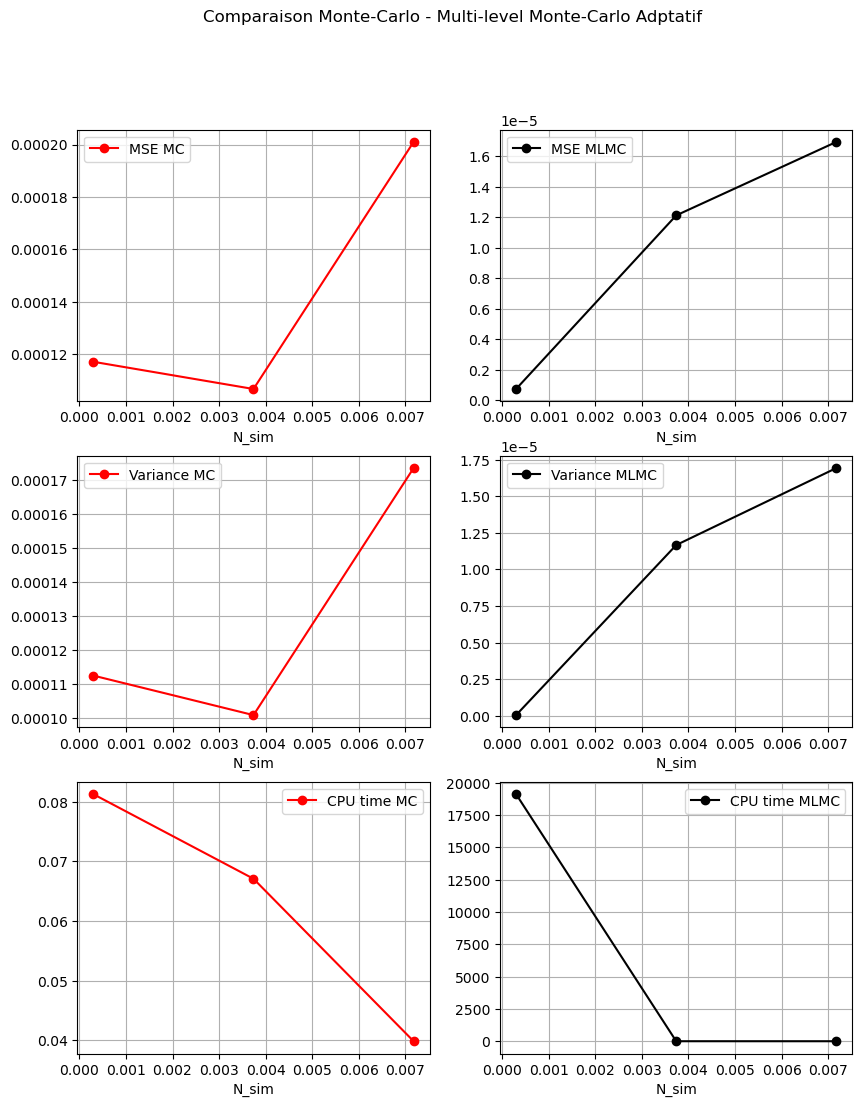

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

plot_perf(axs[0], MSE_MC_eps_cmp, MSE_MC_MLMC_adpt_eps_cmp, 'MSE')
plot_perf(axs[1], var_MC_eps_cmp, var_MC_MLMC_adpt_eps_cmp, 'Variance')
plot_perf(axs[2], cpu_MC_eps_cmp, cpu_MC_MLMC_adpt_eps_cmp, 'CPU time')

plt.suptitle(f'Comparaison Monte-Carlo - Multi-level Monte-Carlo Adptatif\n')
plt.show()